In [23]:
import pandas as pd
import sklearn
import numpy as np
import matplotlib.pyplot as pyplot

from math import sqrt

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.metrics import mean_squared_error

import tensorflow as tf

In [24]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [25]:
dataset = pd.read_csv("../data/cleaned_data/dataset_2.csv", index_col=0).dropna()
dataset.sort_values(by="date", inplace=True)

In [26]:
mean = dataset.groupby("date").agg("mean")
sum_data = dataset.groupby("date").agg("sum")

In [27]:
mean.head()

,cases,deaths,county,state,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,mobility_from_baseline,density
date,,,,,,,,,,,,
0,0.006474,0.000498,642.422311,23.702689,6.452164,2.522317,8.187496,2.429458,0.501082,-0.429773,146.645010,392.320976
1,0.006490,0.000499,643.003495,23.723415,8.231187,2.626350,8.617279,2.073814,0.550769,-0.503705,115.983210,393.251373
2,0.006458,0.000994,643.105315,23.704918,4.873486,-0.028323,13.490169,1.101357,-17.510553,3.261640,122.123701,391.371138
3,0.006958,0.000994,643.172962,23.696819,0.032947,-1.287558,2.476728,1.146480,-0.171386,0.616330,110.079389,391.563763
4,0.006955,0.000994,643.105315,23.704918,2.491628,0.717912,3.985403,1.351177,0.793830,0.137704,110.858286,391.371138


In [28]:
time_series_data = sum_data.iloc[:, :2].join(mean.iloc[:, 3:])
num_feat = len(time_series_data.columns) - 2
values = time_series_data.values.astype('float32')
scaler = sklearn.preprocessing.MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(values)
scaled_data[:5]

array([[0.0000000e+00, 0.0000000e+00, 4.4367981e-01, 8.3800256e-01,
        6.3610798e-01, 3.8774371e-01, 8.3798492e-01, 9.5665818e-01,
        5.9506755e-02, 7.4877417e-01, 6.4256668e-02],
       [0.0000000e+00, 0.0000000e+00, 6.2075806e-01, 8.5984480e-01,
        6.3767755e-01, 3.9646342e-01, 8.2724756e-01, 9.5735818e-01,
        5.5410642e-02, 5.1789188e-01, 1.0899162e-01],
       [0.0000000e+00, 1.0051161e-05, 4.6270752e-01, 8.1862015e-01,
        5.9762567e-01, 4.9532756e-01, 7.9788774e-01, 7.0290494e-01,
        2.6402444e-01, 5.6412959e-01, 1.8585205e-02],
       [5.9434205e-07, 1.0051161e-05, 3.9352417e-01, 7.5918984e-01,
        5.7862717e-01, 2.7188018e-01, 7.9925001e-01, 9.4718426e-01,
        1.1746462e-01, 4.7343627e-01, 2.7847290e-02],
       [5.9434205e-07, 1.0051161e-05, 4.6270752e-01, 7.8937662e-01,
        6.0888433e-01, 3.0248910e-01, 8.0543011e-01, 9.6078253e-01,
        9.0947002e-02, 4.7930130e-01, 1.8585205e-02]], dtype=float32)

In [29]:
scaled_data.shape

(105, 11)

In [30]:

reframed = series_to_supervised(scaled_data, n_in=14, n_out=1)
reframed[:5]

,var1(t-14),var2(t-14),var3(t-14),var4(t-14),var5(t-14),var6(t-14),var7(t-14),var8(t-14),var9(t-14),var10(t-14),...,var2(t),var3(t),var4(t),var5(t),var6(t),var7(t),var8(t),var9(t),var10(t),var11(t)
14,0.000000e+00,0.00000,0.443680,0.838003,0.636108,0.387744,0.837985,0.956658,0.059507,0.748774,...,0.000020,0.524506,0.940031,0.724574,0.447278,0.926646,0.993183,0.000000,0.781590,0.063770
15,0.000000e+00,0.00000,0.620758,0.859845,0.637678,0.396463,0.827248,0.957358,0.055411,0.517892,...,0.000020,1.000000,1.000000,0.774972,0.523049,0.966515,1.000000,0.013260,0.524470,0.188051
16,0.000000e+00,0.00001,0.462708,0.818620,0.597626,0.495328,0.797888,0.702905,0.264024,0.564130,...,0.000070,0.462708,0.889294,0.682896,0.338961,0.816718,0.998576,0.061888,0.484667,0.018526
17,5.943421e-07,0.00001,0.393524,0.759190,0.578627,0.271880,0.799250,0.947184,0.117465,0.473436,...,0.000080,0.393524,0.955899,0.762847,0.425568,0.840960,0.973839,0.049348,0.508338,0.027847
18,5.943421e-07,0.00001,0.462708,0.789377,0.608884,0.302489,0.805430,0.960783,0.090947,0.479301,...,0.000121,0.393524,0.898721,0.701594,0.408075,0.845886,0.977165,0.058062,0.508751,0.027924


In [31]:
reframed.shape

(91, 165)

In [32]:
reframed.drop(reframed.columns[-num_feat:], axis=1, inplace=True)
values=reframed.values

In [33]:
train_size = 80
train, test = values[:train_size, :], values[train_size:, :]
train_X, train_y = train[:, :-2], train[:, -2:]
test_X, test_y = test[:, :-2], test[:, -2:]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(80, 1, 154) (80, 2) (11, 1, 154) (11, 2)


In [34]:
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(2))
model.compile(loss='mae', optimizer='adam')

Train on 80 samples, validate on 11 samples
Epoch 1/100
 - 1s - loss: 0.0459 - val_loss: 0.0693
Epoch 2/100
 - 0s - loss: 0.0770 - val_loss: 0.0440
Epoch 3/100
 - 0s - loss: 0.0649 - val_loss: 0.0513
Epoch 4/100
 - 0s - loss: 0.0530 - val_loss: 0.0575
Epoch 5/100
 - 0s - loss: 0.0647 - val_loss: 0.0449
Epoch 6/100
 - 0s - loss: 0.0467 - val_loss: 0.0409
Epoch 7/100
 - 0s - loss: 0.0444 - val_loss: 0.0261
Epoch 8/100
 - 0s - loss: 0.0699 - val_loss: 0.0368
Epoch 9/100
 - 0s - loss: 0.0718 - val_loss: 0.0394
Epoch 10/100
 - 0s - loss: 0.0456 - val_loss: 0.0492
Epoch 11/100
 - 0s - loss: 0.0316 - val_loss: 0.0338
Epoch 12/100
 - 0s - loss: 0.0341 - val_loss: 0.0260
Epoch 13/100
 - 0s - loss: 0.0422 - val_loss: 0.0221
Epoch 14/100
 - 0s - loss: 0.0356 - val_loss: 0.0277
Epoch 15/100
 - 0s - loss: 0.0297 - val_loss: 0.0271
Epoch 16/100
 - 0s - loss: 0.0273 - val_loss: 0.0300
Epoch 17/100
 - 0s - loss: 0.0315 - val_loss: 0.0383
Epoch 18/100
 - 0s - loss: 0.0399 - val_loss: 0.0231
Epoch 19/10

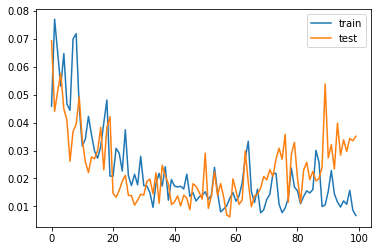

In [35]:
# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=1, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [36]:
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, 2:(num_feat + 2)]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,:2]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 2))
inv_y = np.concatenate((test_y, test_X[:, 2:(num_feat + 2)]), axis=1)
full = scaler.inverse_transform(inv_y)
inv_y = full[:,:2]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 60099.595


In [37]:
inv_y = pd.DataFrame(inv_y)

In [38]:
inv_yhat = pd.DataFrame(inv_yhat)

In [39]:
dates = pd.Series(time_series_data.index[80:])
dates

0      80
1      81
2      82
3      83
4      84
5      85
6      86
7      87
8      88
9      89
10     90
11     91
12     92
13     93
14     94
15     95
16     96
17     97
18     98
19     99
20    100
21    101
22    102
23    103
24    104
Name: date, dtype: int64

In [40]:
results = pd.DataFrame()
results = pd.concat([dates, inv_y, inv_yhat], axis=1)

In [41]:
results.columns = ["date", "cases", "deaths", "cases_hat", "deaths_hat"]

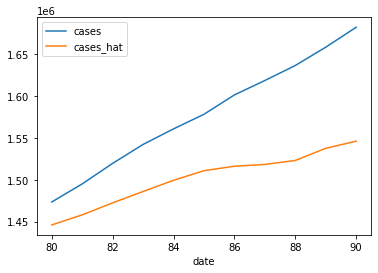

In [42]:
results.plot(x="date", y=["cases", "cases_hat"])

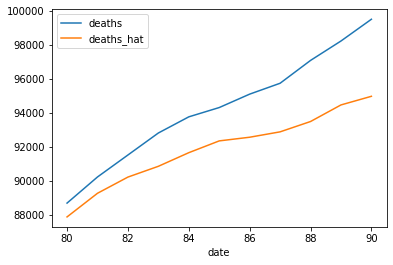

In [43]:
results.plot(x="date", y=["deaths", "deaths_hat"])